In [1]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Video, widgets
from IPython.display import display

%matplotlib inline

In [2]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

In [3]:
def resize_img(img, div=3):
    return cv2.resize(img, (img.shape[1]//div, img.shape[0]//div))

In [4]:
chessboard = cv2.imread("Chess_Data/frame1.jpg")
chessboard.shape

(1080, 1920, 3)

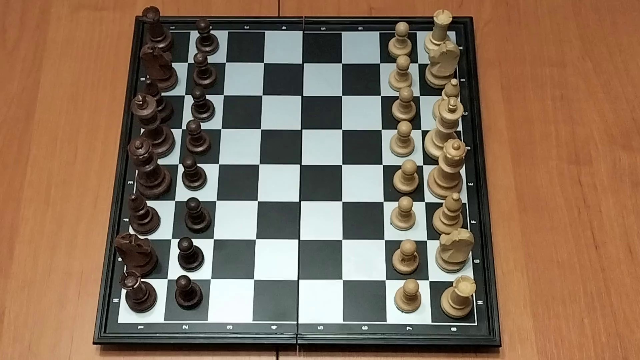

In [5]:
imshow(resize_img(chessboard))

## Calibrate camera

In [6]:
def find_closest_points_to_corners(points, corners):
    closest_points = []
    for corner in corners:
        distances = np.linalg.norm(points - corner, axis=1)
        closest_point_index = np.argmin(distances)
        closest_points.append(points[closest_point_index])
    return np.array(closest_points)

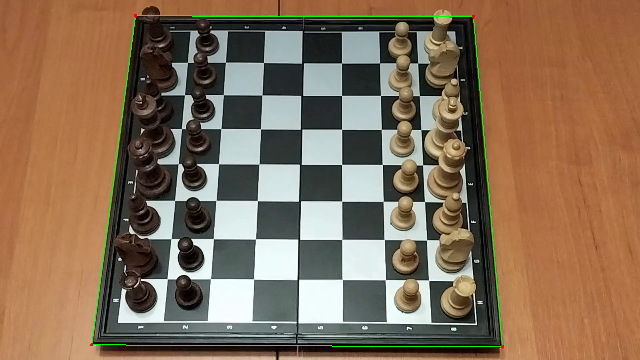

In [7]:
gray = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(gray, 50, 150)

frame_with_boxes = chessboard.copy()
dst = cv2.cornerHarris(blurred, 5, 3, 0.02)
dst = cv2.dilate(dst, None)
corners = np.argwhere(dst > 0.01 * dst.max())

# Find corners closest to image corners
image_corners = np.array([[0, 0], [0, chessboard.shape[1]], [chessboard.shape[0], 0], [chessboard.shape[0], chessboard.shape[1]]])
closest_corners = find_closest_points_to_corners(corners, image_corners)

trapezoid_pts = np.array([[closest_corners[0][1], closest_corners[0][0]], [closest_corners[2][1], closest_corners[2][0]], [closest_corners[3][1], closest_corners[3][0]], [closest_corners[1][1], closest_corners[1][0]]], np.int32)
trapezoid_pts = trapezoid_pts.reshape((-1, 1, 2))
cv2.polylines(frame_with_boxes, [trapezoid_pts], isClosed=True, color=(0, 255, 0), thickness=2)

for corner in closest_corners:
    cv2.circle(frame_with_boxes, tuple(corner[::-1]), 5, (0, 0, 255), -1)

# Display the result
imshow(resize_img(frame_with_boxes))

In [8]:
closest_corners

array([[  47,  406],
       [  50, 1420],
       [1034,  275],
       [1040, 1507]], dtype=int64)

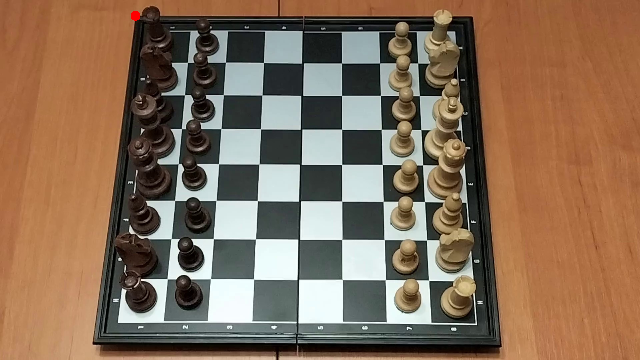

In [9]:
chessboard_copy = chessboard.copy()
cv2.circle(chessboard_copy, closest_corners[0][::-1], 15, (0, 0, 255), -1)
imshow(resize_img(chessboard_copy))

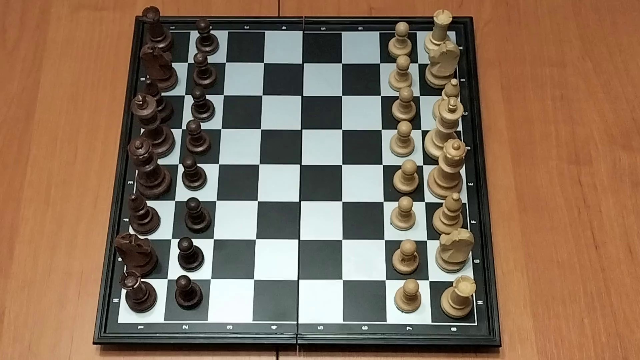

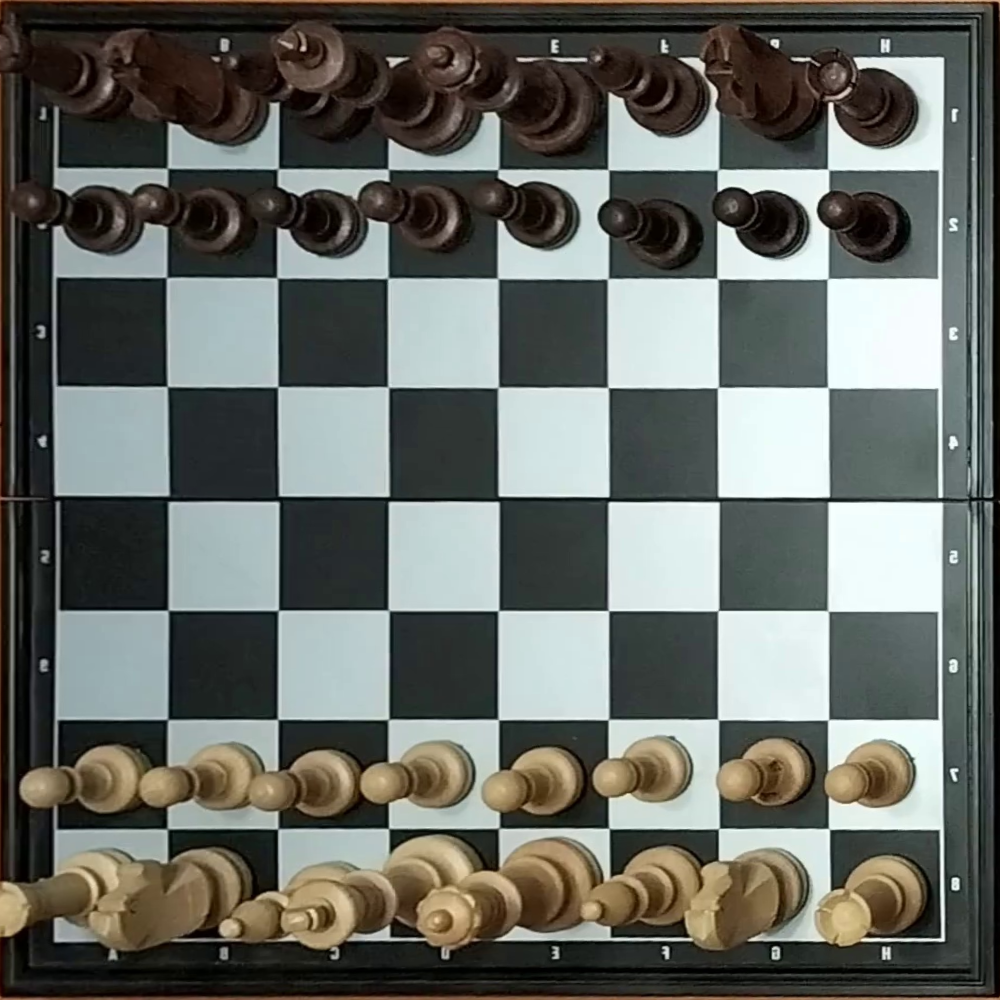

In [10]:
target_square_size = 1000  # Adjust the size as needed
target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)

# Calculate the homography matrix
homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

# Apply the perspective transformation
calibrated_image = cv2.warpPerspective(chessboard, homography_matrix, (target_square_size, target_square_size))

chessboard_copy = chessboard.copy()
imshow(resize_img(chessboard_copy))
imshow(calibrated_image)

In [11]:
calibrated_image.shape

(1000, 1000, 3)

## Create grid

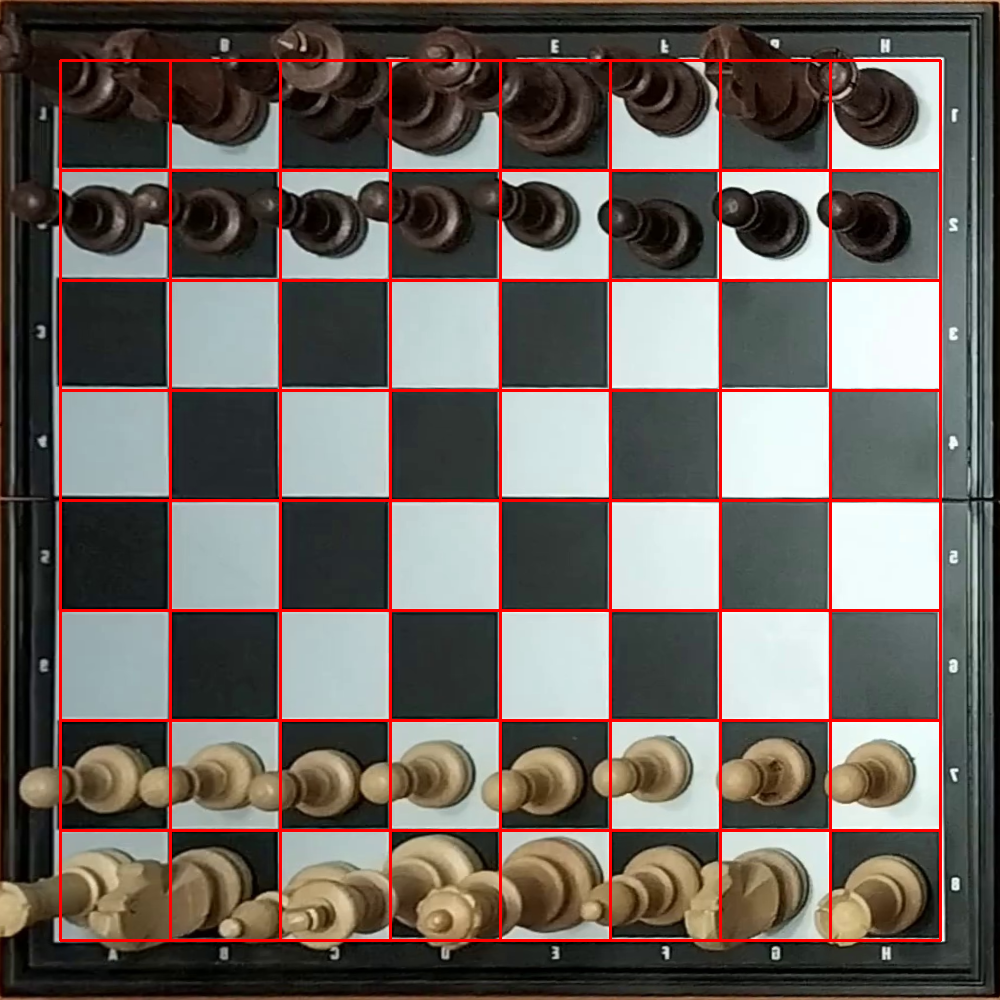

In [12]:
offset = 60
clean_img = calibrated_image.copy()

grid_division = np.linspace(offset, 1000-offset, 9, dtype=int)
for x in grid_division:
    cv2.line(clean_img, (x, 0+offset), (x, 1000-offset), color=(0, 0, 255), thickness=2)  
    cv2.line(clean_img, (0+offset, x), (1000-offset, x), color=(0, 0, 255), thickness=2)  

imshow(clean_img)

#### Calculate square size

In [13]:
square_size = grid_division[1] - grid_division[0]
square_size

110

### Find empty spaces

| A | B | C | D | E | F | G | H |     |
|---|---|---|---|---|---|---|---|-----|
| B | W | B | W | B | W | B | W |**1**|
| W | B | W | B | W | B | W | B |**2**|
| B | W | B | W | B | W | B | W |**3**|
| W | B | W | B | W | B | W | B |**4**|
| B | W | B | W | B | W | B | W |**5**|
| W | B | W | B | W | B | W | B |**6**|
| B | W | B | W | B | W | B | W |**7**|
| W | B | W | B | W | B | W | B |**8**|

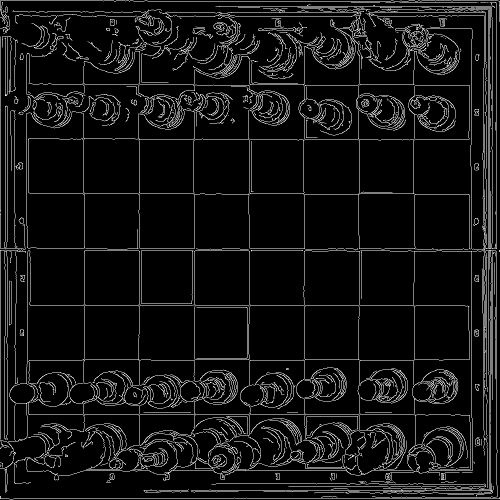

In [14]:
calibrated_gray = cv2.cvtColor(calibrated_image, cv2.COLOR_BGR2GRAY)
calibrated_edges = cv2.Canny(calibrated_gray, 50, 150)
imshow(resize_img(calibrated_edges, 2))

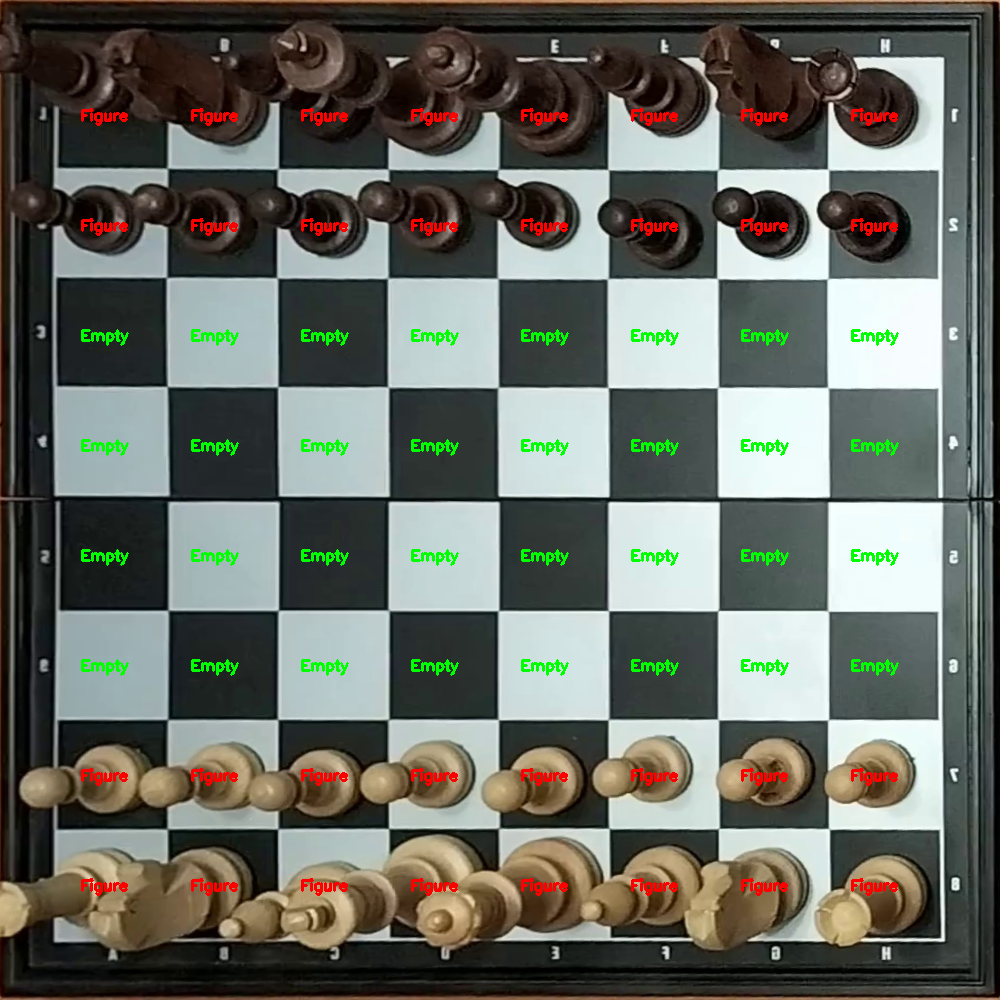

In [21]:
clean_img2 = calibrated_image.copy()

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (0, 0, 255)
thickness = 2

empty_check_offset = 20
kernel_size = square_size - empty_check_offset
artifact_tolerance = 100
col_imgs = []
square_color = "Black"
for x in grid_division[:-1]:
    row_imgs = []
    for y in grid_division[:-1]:
        x_d = x+empty_check_offset//2, x+empty_check_offset//2+kernel_size
        y_d = y+empty_check_offset//2, y+empty_check_offset//2+kernel_size

        edge_board_square = calibrated_edges[x_d[0]:x_d[1], y_d[0]:y_d[1]]
        edge_board_square_bin = np.where(edge_board_square==255, 1, edge_board_square)
        edge_board_square_value = np.sum(edge_board_square_bin)

        row_imgs.append(edge_board_square)
        # imshow(resize_img(edge_board_square, 1))

        if edge_board_square_value > artifact_tolerance:
            # cv2.putText(space_img, f"{square_color} sq", (y+20, x+50), font, font_scale, font_color, thickness)
            cv2.putText(clean_img2, f"Figure", (y+20, x+60), font, font_scale, (0, 0, 255), thickness)

        elif edge_board_square_value <= artifact_tolerance:
            # cv2.putText(space_img, f"{square_color} sq", (y+20, x+50), font, font_scale, font_color, thickness)
            cv2.putText(clean_img, f"Empty", (y+20, x+60), font, font_scale, (0, 255, 0), thickness)

        square_color = "White" if square_color == "Black" else "Black"
             
    square_color = "White" if square_color == "Black" else "Black"

    # imshow(resize_img(np.concatenate(row_imgs, 1), 1))
    col_imgs.append(np.concatenate(row_imgs, 1))

# imshow(resize_img(np.concatenate(col_imgs, 0), 2))
imshow(resize_img(clean_img2, 1))


### Visualize starting position

https://python-chess.readthedocs.io/en/latest/

In [16]:
# !pip install chess

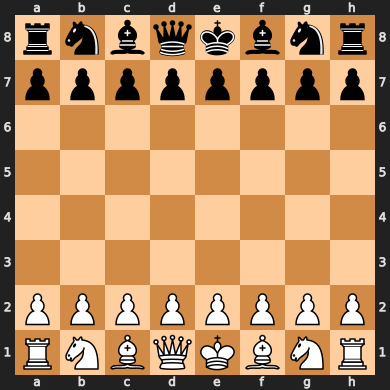

In [17]:
import chess

board = chess.Board()
board